# Import Packages

In [21]:
import pandas as pd
import os
from tqdm import tqdm

# National Vehicle Stock Class

In [136]:
import pandas as pd
import os

class NationalVehicleStockDataProcessor:
    def __init__(self):
        self.vehicle_stock_df_raw = None
        self.piv_stock_df_raw = None
        self.vehicle_stock_df = None
        self.piv_stock_df = None
        self.stock_df = None

    def read_excel_file(self, file_path, details: dict) -> pd.DataFrame:
        return pd.read_excel(
            file_path,
            sheet_name=details['sheet_name'], 
            header=details['header'], 
            engine=details['engine']
        )
    
    def load_raw_data(self, raw_data_path: str, meta_data: dict) -> pd.DataFrame:
        for vehicle_type, details in meta_data.items():
            file_path = os.path.join(raw_data_path, details['file_name'])
            print(f"Loading {vehicle_type} data from {file_path}")
            if vehicle_type == 'vehicle_stock':
                self.vehicle_stock_df_raw = self.read_excel_file(file_path, details)
            elif vehicle_type == 'piv_stock':
                self.piv_stock_df_raw = self.read_excel_file(file_path, details)
        return self.vehicle_stock_df_raw, self.piv_stock_df_raw
    
    def filter_dataframe(self, df_raw: pd.DataFrame, filters: dict) -> pd.DataFrame:
        df = (
            df_raw
            .rename(columns=filters['new_cols'])
            .query(filters['query'])
            .drop(filters['dropped_cols'], axis=1)
            .reset_index(drop=True)
        )
        return df
    
    def process_raw_data(self, filters_dict: dict) -> pd.DataFrame:
        if self.vehicle_stock_df_raw is None or self.piv_stock_df_raw is None:
            raise ValueError('Raw data not loaded. Please load raw data first.')
        
        for vehicle_type, filters in filters_dict.items():
            if vehicle_type == 'vehicle_stock':
                self.vehicle_stock_df = self.filter_dataframe(self.vehicle_stock_df_raw, filters)
                self.vehicle_stock_df.iloc[:, 1:] *= 1000
            elif vehicle_type == 'piv_stock':
                self.piv_stock_df = self.filter_dataframe(self.piv_stock_df_raw, filters)
        
        return self.vehicle_stock_df, self.piv_stock_df
    
    def calculate_stock(self) -> pd.DataFrame:
        total_stock = self.vehicle_stock_df[self.vehicle_stock_df['Fuel'] == 'Total'].drop(['Fuel'], axis=1).iloc[0]
        total_stock.rename('Total', inplace=True)

        icev_stock = self.vehicle_stock_df[self.vehicle_stock_df['Fuel'] == 'Total'].drop(['Fuel'], axis=1).iloc[0] - self.vehicle_stock_df[self.vehicle_stock_df['Fuel'] == 'Other fuels'].drop(['Fuel'], axis=1).iloc[0]
        icev_stock.rename('ICEV', inplace=True)

        ev_stock = self.piv_stock_df[self.piv_stock_df['Fuel'] == 'Total'].drop(['Fuel'], axis=1).iloc[0]
        ev_stock.rename('EV', inplace=True)

        bev_stock = self.piv_stock_df[(self.piv_stock_df['Fuel'] == 'Battery electric') | (self.piv_stock_df['Fuel'] == 'Range extended electric')].drop(['Fuel'], axis=1).sum()
        bev_stock.rename('BEV', inplace=True)

        phev_stock = self.piv_stock_df[(self.piv_stock_df['Fuel'] == 'Plug-in hybrid electric (diesel)') | (self.piv_stock_df['Fuel'] == 'Plug-in hybrid electric (petrol)')].drop(['Fuel'], axis=1).sum()
        phev_stock.rename('PHEV', inplace=True)

        self.stock_df = pd.concat([total_stock, icev_stock, ev_stock, bev_stock, phev_stock], axis=1)[::-1]
        self.stock_df.index.name = 'Date'

        return self.stock_df
    
    def run_pipeline(self, raw_data_path: str, meta_data: dict, filters_dict: dict):
        self.load_raw_data(raw_data_path, meta_data)
        self.process_raw_data(filters_dict)
        self.calculate_stock()
        print('Pipeline run successfully')

    def save_data(self, save_path: str, year_quarter: str):
        self.stock_df.to_csv(os.path.join(save_path, f'stock_df_{year_quarter}.csv'))
        print('Data saved successfully')

In [137]:
national_vehicle_stock_data_processor = NationalVehicleStockDataProcessor()
raw_data_path = '../data/large_datasets/vehicle_registrations/raw_data'
meta_data = {
    'vehicle_stock': {
        'file_name': 'veh0105_2023_Q4.ods',
        'sheet_name': 'VEH0105',
        'header': 4,
        'engine': 'odf'
    },
    'piv_stock': {
        'file_name': 'veh0142_2023_Q4.ods',
        'sheet_name': 'VEH0142',
        'header': 4,
        'engine': 'odf'
    }
}
filters_dict = {
    'vehicle_stock': {
        'new_cols': {
            'Fuel [note 2]': 'Fuel',
            'Keepership [note 3]': 'Keepership',
            'ONS Geography [note 6]': 'Geography',
        },
        'query': "Geography == 'England' & Units == 'Thousands' & BodyType == 'Cars' & Keepership == 'Total'",
        'dropped_cols': [
            'Units', 
            'Geography', 
            'BodyType', 
            'Keepership',
            'ONS Sort [note 6]',
            'ONS Code [note 6]'
        ]
    },
    'piv_stock': {
        'new_cols': {
            'Fuel [note 2]': 'Fuel',
            'Keepership [note 3]': 'Keepership',
            'ONS Geography [note 6]': 'Geography',
        },
        'query': "Geography == 'England' & Units == 'Number' & BodyType == 'Cars' & Keepership == 'Total'",
        'dropped_cols': [
            'Units', 
            'Geography', 
            'BodyType', 
            'Keepership',
            'ONS Sort [note 6]',
            'ONS Code [note 6]'
        ]
    }
}
national_vehicle_stock_data_processor.run_pipeline(raw_data_path, meta_data,  filters_dict)
national_vehicle_stock_data_processor.save_data('../data/large_datasets/vehicle_registrations/processed_data', '2023_Q4')

Loading vehicle_stock data from ../data/large_datasets/vehicle_registrations/raw_data/veh0105_2023_Q4.ods
Loading piv_stock data from ../data/large_datasets/vehicle_registrations/raw_data/veh0142_2023_Q4.ods
Pipeline run successfully
Data saved successfully


<Axes: >

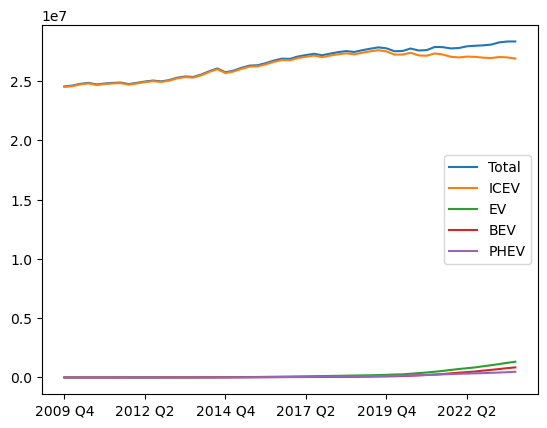

In [107]:
national_vehicle_stock_data_processor.stock_df.plot()

# National Vehicle Sales Class

In [130]:
import pandas as pd
import os

class NationalVehicleSalesDataProcessor:
    def __init__(self):
        self.vehicle_sales_df_raw = None
        self.vehicle_sales_df = None
        self.sales_df = None

    def read_excel_file(self, file_path, details: dict) -> pd.DataFrame:
        return pd.read_excel(
            file_path,
            sheet_name=details['sheet_name'], 
            header=details['header'], 
            engine=details['engine']
        )
    
    def load_raw_data(self,raw_data_path: str, meta_data: dict ) -> pd.DataFrame:
        file_path = os.path.join(raw_data_path, meta_data['file_name'])
        print(f"Loading data from {file_path}")
        self.vehicle_sales_df_raw = self.read_excel_file(file_path, meta_data)
        return self.vehicle_sales_df_raw
    
    def process_raw_data(self, filters_dict: dict) -> pd.DataFrame:
        if self.vehicle_sales_df_raw is None:
            raise ValueError('Raw data not loaded. Please load raw data first.')
        vehicle_sales_df = (
            self.vehicle_sales_df_raw.rename(columns=filters_dict['new_cols'])
            .query(filters_dict['query'])
            .drop(filters_dict['dropped_cols'], axis=1)
            .reset_index(drop=True)
        )
        vehicle_sales_df['Date'] = vehicle_sales_df['Date'].str.replace(r"\(.*\)","", regex=True).str.strip()
        vehicle_sales_df.set_index('Date', inplace=True)
        vehicle_sales_df.iloc[:, :] = vehicle_sales_df.iloc[:, :]*1000
        vehicle_sales_df['ICEV'] = (
            vehicle_sales_df['Petrol'] + 
            vehicle_sales_df['Diesel'] + 
            vehicle_sales_df['Hybrid electric (petrol)'] + 
            vehicle_sales_df['Hybrid electric (diesel)']
        )
        self.vehicle_sales_df = vehicle_sales_df
        return self.vehicle_sales_df
    
    def calculate_sales(self) -> pd.DataFrame:
        total_sales = (self.vehicle_sales_df['Total'])
        total_sales.rename('Total', inplace=True)

        icev_sales = self.vehicle_sales_df['ICEV']
        icev_sales.rename('ICEV', inplace=True)

        ev_sales = self.vehicle_sales_df['EV']
        ev_sales.rename('EV', inplace=True)

        bev_sales = self.vehicle_sales_df['BEV'] + self.vehicle_sales_df['REX']
        bev_sales.rename('BEV', inplace=True)

        phev_sales = (self.vehicle_sales_df['PHEV_P']+self.vehicle_sales_df['PHEV_D'] )
        phev_sales.rename('PHEV', inplace=True)

        self.sales_df = pd.concat([total_sales, icev_sales, ev_sales, bev_sales, phev_sales], axis=1)

        return self.sales_df
    
    def run_pipeline(self, raw_data_path: str, meta_data: dict, filters_dict: dict):
        self.load_raw_data(raw_data_path, meta_data)
        self.process_raw_data(filters_dict)
        self.calculate_sales()
        print('Pipeline run successfully')

    def save_data(self, save_path: str, year_quarter: str):
        self.sales_df.to_csv(os.path.join(save_path, f'sales_df_{year_quarter}.csv'))
        print('Data saved successfully')

In [133]:
national_vehicle_sales_data_processor = NationalVehicleSalesDataProcessor()
raw_data_path = '../data/large_datasets/vehicle_registrations/raw_data'
meta_data = {
    'file_name': 'veh1153_2023_Q4.ods',
    'sheet_name': 'VEH1153a_RoadUsing',
    'header': 4,
    'engine': 'odf'
}
filters_dict = {
    'new_cols': {
        'Geography [note 4]': 'Geography',
        'Date Interval [note 5]': 'DateInterval',
        'Date [note 5]': 'Date',
        'Battery electric': 'BEV',
        'Plug-in hybrid electric (petrol)': 'PHEV_P',
        'Plug-in hybrid electric (diesel)': 'PHEV_D',
        'Range extended electric': 'REX',
        'Fuel cell electric': 'FCEV',
        'Plugin [note 8]': 'EV',
    },
    'query': "Geography == 'England' & DateInterval == 'Quarterly' & Units == 'Thousands' & BodyType == 'Cars' & Keepership == 'Total'",
    'dropped_cols': [
        'Geography',
        'DateInterval',
        'Units',
        'BodyType',
        'Keepership'
    ]
}
national_vehicle_sales_data_processor.run_pipeline(raw_data_path, meta_data, filters_dict)
national_vehicle_sales_data_processor.save_data('../data/large_datasets/vehicle_registrations/processed_data', '2023_Q4')

Loading data from ../data/large_datasets/vehicle_registrations/raw_data/veh1153_2023_Q4.ods
Pipeline run successfully
Data saved successfully


In [135]:
national_vehicle_sales_data_processor.sales_df

,Total,ICEV,EV,BEV,PHEV
Date,,,,,
2001 Q1,625884.0,624935.0,19.0,16.0,3.0
2001 Q2,546848.0,546528.0,9.0,9.0,0.0
2001 Q3,639234.0,639012.0,45.0,45.0,0.0
2001 Q4,470546.0,469992.0,11.0,11.0,0.0
2002 Q1,665906.0,665190.0,6.0,5.0,1.0
...,...,...,...,...,...
2022 Q4,360504.0,251401.0,108198.0,83747.0,24451.0
2023 Q1,431201.0,333323.0,97360.0,68888.0,28472.0
2023 Q2,394436.0,297358.0,96846.0,69242.0,27604.0


<Axes: xlabel='Date'>

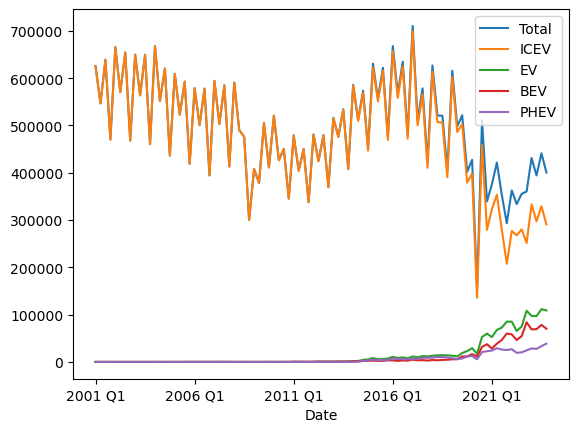

In [110]:
national_vehicle_sales_data_processor.sales_df.plot()

# LSOA Registrations Class

In [139]:
import numpy as np
import pandas as pd
import os

class LSOAVehicleRegistrationDataProcessor:
    def __init__(self, lsoa_lookup_path: str):
        self.v_reg_df_raw = None
        self.v_reg_df = None
        self.piv_reg_df_raw = None
        self.piv_reg_df = None
        self.lsoa_lookup = pd.read_csv(lsoa_lookup_path)
        self.ev_reg_df = None
        self.bev_reg_df = None
        self.phev_reg_df = None
        self.icev_reg_df = None

    def apply_dtypes(self, first: int, last: int) -> dict:
        dtypes = {i: str for i in range(first)}
        dtypes.update({i: float for i in range(first, last)})
        return dtypes
    
    def load_csv(self, filepath: str, details: dict) -> pd.DataFrame:
        csv_df = pd.read_csv(
            filepath, 
            dtype=self.apply_dtypes(details['first'], details['last']),
            na_values=details['na_values']
        )
        return csv_df
    
    def load_raw_data(self, raw_data_path: str, meta_data: dict):
        for vehicle_type, details in meta_data.items():
            file_path = os.path.join(raw_data_path, details['file_name'])
            print(f"Loading {vehicle_type} data from {file_path}")
            if vehicle_type == 'v_reg':
                self.v_reg_df_raw = self.load_csv(file_path, details)
            elif vehicle_type == 'piv_reg':
                self.piv_reg_df_raw = self.load_csv(file_path, details)
        return self.v_reg_df_raw, self.piv_reg_df_raw
    
    def filter_dataframe(self, df_raw: pd.DataFrame, filters: dict, LAD: str) -> pd.DataFrame:
        df = (
            df_raw
            .query(filters['query'])
            .drop(filters['dropped_cols'], axis=1)
            .merge(self.lsoa_lookup.loc[:, ['LSOA11CD', 'LAD22NM']], on='LSOA11CD', how='outer')
            .loc[lambda x: x['LAD22NM'] == LAD] # Filter for target Local Authority
            .drop(columns = ['LAD22NM'])
            .set_index('LSOA11CD')
        )
        return df
    
    def process_raw_data(self, filters_dict: dict, LAD: str) -> pd.DataFrame:
        if self.v_reg_df_raw is None or self.piv_reg_df_raw is None:
            raise ValueError('Raw data not loaded. Please load raw data first.')
        for vehicle_type, filters in filters_dict.items():
            if vehicle_type == 'v_reg':
                v_reg_df = self.filter_dataframe(self.v_reg_df_raw, filters, LAD)
                self.v_reg_df = v_reg_df[~v_reg_df.index.duplicated(keep='first')].T.iloc[::-1]
            elif vehicle_type == 'piv_reg':
                self.piv_reg_df = self.filter_dataframe(self.piv_reg_df_raw, filters, LAD)
        
        return self.v_reg_df, self.piv_reg_df
    
    def disaggregate_data(self) -> pd.DataFrame:
        template_piv_reg_df = pd.DataFrame(index=self.piv_reg_df.index.unique(), columns=self.piv_reg_df.columns[1:], data=0)

        ev_reg_df = template_piv_reg_df + self.piv_reg_df.query("Fuel == 'Total'").drop(columns = ['Fuel']).astype(float)
        ev_reg_df = ev_reg_df[~ev_reg_df.index.duplicated(keep='first')].T.iloc[::-1]
        self.ev_reg_df = ev_reg_df

        bev_reg_df = template_piv_reg_df + self.piv_reg_df.query("Fuel == 'Battery electric'").drop(columns = ['Fuel']).astype(float)
        bev_reg_df = bev_reg_df[~bev_reg_df.index.duplicated(keep='first')].T.iloc[::-1]
        self.bev_reg_df = bev_reg_df

        phev_reg_df = template_piv_reg_df + self.piv_reg_df.query("Fuel == 'Plug-in hybrid electric (petrol)'").drop(columns = ['Fuel']).astype(float)
        phev_reg_df = phev_reg_df[~phev_reg_df.index.duplicated(keep='first')].T.iloc[::-1]
        self.phev_reg_df = phev_reg_df

        return self.ev_reg_df, self.bev_reg_df, self.phev_reg_df
    
    def fill_missing_bev_and_phev_data(self):
        # Fill instances where total and PHEV are known but BEV is unknown
        BOOL = self.ev_reg_df.notna() & self.bev_reg_df.isna() & self.phev_reg_df.notna()
        self.bev_reg_df[BOOL] = self.ev_reg_df[BOOL] - self.phev_reg_df[BOOL]

        # Fill instances where total and BEV are known but PHEV is unknown
        BOOL = self.ev_reg_df.notna() & self.bev_reg_df.notna() & self.phev_reg_df.isna()
        self.phev_reg_df[BOOL] = self.ev_reg_df[BOOL] - self.bev_reg_df[BOOL]

        # Fill instances where total is known but BEV and PHEV are unknown
        BOOL = self.ev_reg_df.notna() & self.bev_reg_df.isna() & self.phev_reg_df.isna()
        bev_split = (self.bev_reg_df.sum(axis=1)/(self.bev_reg_df.sum(axis=1) + self.phev_reg_df.sum(axis=1))).fillna(0.5)
        phev_split = (self.phev_reg_df.sum(axis=1)/(self.bev_reg_df.sum(axis=1) + self.phev_reg_df.sum(axis=1))).fillna(0.5)
        self.bev_reg_df[BOOL] = round(bev_split*self.ev_reg_df[BOOL])
        self.phev_reg_df[BOOL] = round(phev_split*self.ev_reg_df[BOOL])

        return self.bev_reg_df, self.phev_reg_df
    
    def calculate_t0(self, data: pd.Series | pd.DataFrame) -> float:
        """
        Returns the first (and oldest) date (assuming date is the index) 
        of a Pandas Series or DataFrame
        """
        year = int(data.head(1).index[0][:4])
        quarter = data.head(1).index[0][-2:]
        if quarter == 'Q1':
            t0 = year + 0
        elif quarter == 'Q2':
            t0 = year + 0.25
        elif quarter == 'Q3':
            t0 = year + 0.5
        elif quarter == 'Q4':
            t0 = year + 0.75
        return t0
    
    def calculate_t_present(self, data: pd.Series | pd.DataFrame) -> float:
        """
        Returns the last (and most recent) date (assuming date is the index) 
        of a Pandas Series or DataFrame
        """
        year = int(data.tail(1).index[0][:4])
        quarter = data.tail(1).index[0][-2:]
        if quarter == 'Q1':
            t_present = year + 0
        elif quarter == 'Q2':
            t_present = year + 0.25
        elif quarter == 'Q3':
            t_present = year + 0.5
        elif quarter == 'Q4':
            t_present = year + 0.75    
        return t_present
    
    def calculate_date_range(self, t0: float, t1: float, sample_rate=4) -> np.array:
        # sample_rate = 4 implies quarterly data
        return np.linspace(t0, t1, int((t1-t0)*sample_rate) + 1)
    
    def interpolate_col(self, col: pd.Series) -> pd.Series:
        dates = self.calculate_date_range(self.calculate_t0(col), self.calculate_t_present(col))
        mask = ~col.isna().values
        if mask.any():
            xp = dates[mask]
            fp = col[mask]
            x = dates
            interpolated = np.round(np.interp(x, xp, fp))
            return pd.Series(data=interpolated, index=col.index)
        else:
            return pd.Series(data=np.nan, index=col.index)
    
    def interpolate_df(self, df: pd.DataFrame) -> pd.DataFrame:
        interpolated_df = df.apply(self.interpolate_col, axis=0)
        interpolated_df = interpolated_df.fillna(0)
        return interpolated_df
    
    def interpolate_piv_reg_data(self):
        # Set first data point to 1 if NaN
        self.ev_reg_df.iloc[0, self.ev_reg_df.iloc[0].isna()] = 1
        self.bev_reg_df.iloc[0, self.bev_reg_df.iloc[0].isna()] = 1
        self.phev_reg_df.iloc[0, self.phev_reg_df.iloc[0].isna()] = 1

        # Interpolate missing values
        self.ev_reg_df = self.interpolate_df(self.ev_reg_df)
        self.bev_reg_df = self.interpolate_df(self.bev_reg_df)
        self.phev_reg_df = self.interpolate_df(self.phev_reg_df)
        return self.ev_reg_df, self.bev_reg_df, self.phev_reg_df
    
    def infer_icev_reg_data(self):
        self.icev_reg_df = self.v_reg_df - self.ev_reg_df
        self.icev_reg_df[self.icev_reg_df.isna()] = self.v_reg_df[self.icev_reg_df.isna()]
        return self.icev_reg_df
    
    def run_pipeline(self, raw_data_path: str, meta_data: dict, filters_dict: dict, LAD: str):
        self.load_raw_data(raw_data_path, meta_data)
        self.process_raw_data(filters_dict, LAD)
        self.disaggregate_data()
        self.fill_missing_bev_and_phev_data()
        self.interpolate_piv_reg_data()
        self.infer_icev_reg_data()
        print('Pipeline run successfully')

    def save_data(self, save_path: str, year_quarter: str):
        dataframes = {
            'v_lsoa': self.v_reg_df,
            'ev_lsoa': self.ev_reg_df,
            'bev_lsoa': self.bev_reg_df,
            'phev_lsoa': self.phev_reg_df,
            'icev_lsoa': self.icev_reg_df
        }
        
        for name, df in dataframes.items():
            df.index.name = 'Date'
            df.to_csv(os.path.join(save_path, f'{name}_{year_quarter}.csv'))
        
        print('Data saved successfully')
        

In [140]:
lsoa_vehicle_registration_data_processor = LSOAVehicleRegistrationDataProcessor(
    lsoa_lookup_path='../data/large_datasets/spatial/LSOA_(2011)_to_LSOA_(2021)_to_Local_Authority_District_(2022)_Lookup_for_England_and_Wales_(Version_2).csv'
    )
raw_data_path = '../data/large_datasets/vehicle_registrations/raw_data'
meta_data = {
    'v_reg': {
        'file_name': 'df_VEH0125_2023_Q4.csv',
        'first': 5,
        'last': 57,
        'na_values': ['[c]', '[x]'],
    },
    'piv_reg': {
        'file_name': 'df_VEH0145_2023_Q4.csv',
        'first': 5,
        'last': 56,
        'na_values': ['[c]', '[x]'],
    }
}
filters_dict = {
    'v_reg': {
        'query': "BodyType == 'Cars' and Keepership == 'Private' and LicenceStatus == 'Licensed'",
        'dropped_cols': ['BodyType', 'Keepership', 'LicenceStatus', 'LSOA11NM']
    },
    'piv_reg': {
        'query': "Keepership == 'Private'",
        'dropped_cols': ['Keepership', 'LSOA11NM'] 
    }
}
LAD = 'Bath and North East Somerset'
lsoa_vehicle_registration_data_processor.run_pipeline(raw_data_path, meta_data, filters_dict, LAD)
lsoa_vehicle_registration_data_processor.save_data('../data/large_datasets/vehicle_registrations/processed_data', '2023_Q4')

Loading v_reg data from ../data/large_datasets/vehicle_registrations/raw_data/df_VEH0125_2023_Q4.csv
Loading piv_reg data from ../data/large_datasets/vehicle_registrations/raw_data/df_VEH0145_2023_Q4.csv
Pipeline run successfully
Data saved successfully


# Vehicle Stock Model Data Prepper

In [141]:
class VehicleStockModelDataPrepper:
    def __init__(self):
        self.stock_eng = None
        self.additions_eng = None
        self.removals_eng = None
        self.v_lsoa = None
        self.icev_lsoa = None
        self.ev_lsoa = None
        self.bev_lsoa = None
        self.phev_lsoa = None
        self.data_dict = None
        self.annual_data_dict = None
        self.lsoa_subset = None
        self.model_variables_dict = None

    def load_processed_data(self, data_path: str, file_names: dict) -> None:
        for attr, file_name in file_names.items():
            df = pd.read_csv(os.path.join(data_path, file_name)).set_index('Date').astype(float)
            setattr(self, attr, df)
    
    def calculate_removals(self) -> pd.DataFrame:
        self.removals_eng = self.additions_eng - self.stock_eng.diff() 
        return self.removals_eng

    def create_data_dict(self) -> dict:
        self.data_dict = {
            'stock_eng': self.stock_eng,
            'additions_eng': self.additions_eng,
            'removals_eng': self.removals_eng,
            'v_lsoa': self.v_lsoa,
            'icev_lsoa': self.icev_lsoa,
            'ev_lsoa': self.ev_lsoa,
            'bev_lsoa': self.bev_lsoa,
            'phev_lsoa': self.phev_lsoa
        }
        return self.data_dict
    
    def select_lsoa_subset(self, df: pd.DataFrame, lsoa_subset: int | list) -> pd.DataFrame:
        if isinstance(lsoa_subset, list):
            self.lsoa_subset = lsoa_subset
            if set(lsoa_subset).issubset(df.columns):
                return df[lsoa_subset]
            else:
                raise ValueError("Subset must be a list of LSOA names that are present in the DataFrame.")
        elif isinstance(lsoa_subset, int):
            self.lsoa_subset = df.columns[:lsoa_subset]
            if lsoa_subset < len(df.columns):
                return df.iloc[:, :lsoa_subset]
            else:
                raise ValueError("Subset size must be less than the number of columns in the DataFrame.")
        else:
            raise ValueError("Subset must be either a list of LSOA names or an integer representing the size of the subset.")
    
    def convert_quarter_index_to_float(self, index: pd.Index) -> float:
        year, quarter = index.split(' Q')
        year = int(year)
        quarter = int(quarter)
        quarter_to_float = {1: 0.0, 2: 0.25, 3: 0.5, 4: 0.75}
        return year + quarter_to_float[quarter]
    
    def annualise_data_sum(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        df['Year'] = df.index.astype(int)
        return df.groupby('Year').sum()
    
    def annualise_data_mean(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        df['Year'] = df.index.astype(int)
        return df.groupby('Year').mean().round()
    
    def annualise_data(self, df: pd.DataFrame, key: str) -> pd.DataFrame:
        if key == 'additions_eng' or key == 'removals_eng':
            df_y = self.annualise_data_sum(df)
        else:
            df_y = self.annualise_data_mean(df)
        return df_y
    
    def select_date_range(self, df: pd.DataFrame, t_0_raw: int, t_n: int) -> pd.DataFrame:
        return df.loc[t_0_raw:t_n]
    
    def calculate_market_share(self, df: pd.DataFrame, total: pd.DataFrame) -> pd.DataFrame:
        return (df / total)
    
    def create_model_variables(self, t_0) -> dict:
        A_v = self.annual_data_dict['additions_eng']['Total'].loc[t_0:].to_numpy()
        R_v = self.annual_data_dict['removals_eng']['Total'].loc[t_0:].to_numpy()
        total_vehicles = self.annual_data_dict['stock_eng']['Total'].loc[t_0:].to_numpy()

        V_l = self.annual_data_dict['v_lsoa'].loc[t_0:].to_numpy().T
        V_ev_l = self.annual_data_dict['ev_lsoa'].loc[t_0:].to_numpy().T
        V_bev_l = self.annual_data_dict['bev_lsoa'].loc[t_0:].to_numpy().T
        V_phev_l = self.annual_data_dict['phev_lsoa'].loc[t_0:].to_numpy().T

        delta_V_l_obs = self.annual_data_dict['v_lsoa'].diff().loc[t_0:].to_numpy().T
        delta_V_ev_l_obs = self.annual_data_dict['ev_lsoa'].diff().loc[t_0:].to_numpy().T
        delta_V_bev_l_obs = self.annual_data_dict['bev_lsoa'].diff().loc[t_0:].to_numpy().T
        delta_V_phev_l_obs = self.annual_data_dict['phev_lsoa'].diff().loc[t_0:].to_numpy().T

        L, T = V_l.shape

        self.model_variables_dict = {
            'A_v': A_v,
            'R_v': R_v,
            'total_vehicles': total_vehicles,
            'V_l': V_l,
            'V_ev_l': V_ev_l,
            'V_bev_l': V_bev_l,
            'V_phev_l': V_phev_l,
            'delta_V_l_obs': delta_V_l_obs,
            'delta_V_ev_l_obs': delta_V_ev_l_obs,
            'delta_V_bev_l_obs': delta_V_bev_l_obs,
            'delta_V_phev_l_obs': delta_V_phev_l_obs,
            'L': L,
            'T': T
        }

        return self.model_variables_dict
        
    def prepare_data(self, data_path: str, file_names: dict, lsoa_subset: int | list, t_0: int, t_0_raw: int, t_n: int) -> None:
        self.load_processed_data(data_path, file_names)
        self.calculate_removals()
        self.create_data_dict()
        self.data_dict = {k: self.select_lsoa_subset(df, lsoa_subset) if not k.endswith('_eng') else df for k, df in self.data_dict.items()}
        self.data_dict = {k: df.set_index(df.index.map(self.convert_quarter_index_to_float)) for k, df in self.data_dict.items()}
        self.annual_data_dict = {k: self.annualise_data(df, k) for k, df in self.data_dict.items()}
        self.annual_data_dict = {k: self.select_date_range(df, t_0_raw, t_n) for k, df in self.annual_data_dict.items()}
        self.annual_data_dict['ev_market_share'] = self.calculate_market_share(self.annual_data_dict['ev_lsoa'], self.annual_data_dict['v_lsoa'])
        self.annual_data_dict['bev_market_share'] = self.calculate_market_share(self.annual_data_dict['bev_lsoa'], self.annual_data_dict['v_lsoa'])
        self.annual_data_dict['phev_market_share'] = self.calculate_market_share(self.annual_data_dict['phev_lsoa'], self.annual_data_dict['v_lsoa'])
        self.create_model_variables(t_0)

In [142]:
vehicle_stock_model_data_prepper = VehicleStockModelDataPrepper()
file_names = {
    'stock_eng': 'stock_df_2023_Q4.csv',
    'additions_eng': 'sales_df_2023_Q4.csv',
    'v_lsoa': 'v_lsoa_2023_Q4.csv',
    'icev_lsoa': 'icev_lsoa_2023_Q4.csv',
    'ev_lsoa': 'ev_lsoa_2023_Q4.csv',
    'bev_lsoa': 'bev_lsoa_2023_Q4.csv',
    'phev_lsoa': 'phev_lsoa_2023_Q4.csv'
}
vehicle_stock_model_data_prepper.prepare_data(
    data_path='../data/large_datasets/vehicle_registrations/processed_data', 
    file_names=file_names, 
    lsoa_subset=5, 
    t_0=2012,
    t_0_raw=2011, 
    t_n=2023)

In [143]:
annual_data_dict = vehicle_stock_model_data_prepper.annual_data_dict
annual_data_dict['ev_market_share']

,E01014370,E01014371,E01014372,E01014373,E01014374
Year,,,,,
2011,0.000000,0.000000,0.000000,0.000000,0.001582
2012,0.000000,0.000000,0.000000,0.000000,0.001597
2013,0.000000,0.000000,0.000000,0.000000,0.001597
2014,0.000000,0.000000,0.000000,0.000000,0.000000
2015,0.000000,0.000000,0.000000,0.000000,0.000000
2016,0.002809,0.000000,0.000000,0.000000,0.000000
2017,0.005587,0.000000,0.003914,0.002714,0.000000
2018,0.008152,0.000000,0.007859,0.004132,0.002994
2019,0.010989,0.000000,0.010661,0.006748,0.008772


In [144]:
vehicle_stock_model_data_prepper.model_variables_dict['V_l']

array([[386., 369., 362., 356., 356., 358., 368., 364., 365., 380., 356.,
        356.],
       [543., 543., 560., 536., 531., 523., 518., 508., 511., 524., 511.,
        524.],
       [542., 542., 534., 527., 518., 511., 509., 469., 473., 509., 504.,
        502.],
       [681., 686., 697., 723., 738., 737., 726., 741., 748., 762., 761.,
        773.],
       [626., 626., 632., 646., 650., 654., 668., 684., 712., 744., 757.,
        753.]])